In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, date, time
from pandas.tseries.offsets import *
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.offsets import CustomBusinessDay
from uszipcode import SearchEngine, Zipcode
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

In [251]:
df = pd.read_csv(r'C:\Users\winni\Desktop\GradSchool\Machine Learning\Project\train.tsv', sep='\t',nrows = 300000)

In [ ]:
df.shape

In [ ]:
'''#US federal holidays for 2018 and 2019
# Exclude weekends and US federal holidays
dr = pd.date_range(start='2018-01-01', end='2020-12-31')
fed_hol = pd.DataFrame()
fed_hol['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

fed_hol['Holiday'] = fed_hol['Date'].isin(holidays)
hld = fed_hol[fed_hol['Holiday']==1].values.astype('datetime64[D]')
print(hld.flatten())'''

In [164]:
dr = pd.date_range(start='2018-01-01', end='2020-12-31')
fed_hol = pd.DataFrame()
fed_hol['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

fed_hol['Holiday'] = fed_hol['Date'].isin(holidays)
hld = fed_hol[fed_hol['Holiday']==1].values.astype('datetime64[D]')

handling_time = []
delivery_time = []
total_time_bd = []
total_time_cd = []

counter = 0
for t in range(df.shape[0]):
    counter += 1
    if counter % 500000 == 0:
      print(counter)
    
    acceptance_time = datetime.fromisoformat(df['acceptance_scan_timestamp'][t][0:10])
    payment_time = datetime.fromisoformat(df['payment_datetime'][t][0:10])
    handling_time.append(np.busday_count(df['payment_datetime'][t][0:10], df['acceptance_scan_timestamp'][t][0:10], holidays = hld.flatten()))
    #total_time_bd.append(np.busday_count(df['payment_datetime'][t][0:10], df['delivery_date'][t],holidays = hld.flatten()))
        #if payment is made past cutoff on a weekday, it is considered next business day
    if payment_time.hour >= 14 and payment_time.weekday() < 5:
        handling_time[t] = handling_time[t] - 1
        #total_time_bd[t] = total_time_bd[t] - 1
    delivery = abs(datetime.fromisoformat(df['delivery_date'][t]) - acceptance_time)
    total = datetime.fromisoformat(df['delivery_date'][t]) - payment_time
    delivery_time.append(delivery.days)
    #print(delivery)
    #delivery_time_seconds.append(delivery.days)
    total_time_cd.append(total.days)
    if datetime.fromisoformat(df['delivery_date'][t]) < acceptance_time:
        total_time_bd.append((datetime.fromisoformat(df['delivery_date'][t]) - payment_time).days)
    else: total_time_bd.append(delivery.days + handling_time[t])
    
df['delivery_time_buss_days'] = total_time_bd
df['seller_handling_days'] = handling_time

In [165]:
# Solving missing weights
tmp = df[df['weight'] > 0].copy()
mean = np.mean(tmp['weight'])
median = np.median(tmp['weight'])

new_weight = np.where(df['weight'] > 0, df['weight'], median)
df['new_weight'] = new_weight
# Number of rows with unavailable weight
print(len(df[df['new_weight'] == 0]), median, mean)

0 9.0 23.428284005130262


In [166]:
hld_dt64 = hld[:,0]
hld_dt64

array(['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
       '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
       '2018-11-22', '2018-12-25', '2019-01-01', '2019-01-21',
       '2019-02-18', '2019-05-27', '2019-07-04', '2019-09-02',
       '2019-10-14', '2019-11-11', '2019-11-28', '2019-12-25',
       '2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25',
       '2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11',
       '2020-11-26', '2020-12-25'], dtype='datetime64[D]')

In [4]:
df.columns

Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number', 'delivery_time_buss_days', 'seller_handling_days'],
      dtype='object')

In [213]:
def add_business_days(start_date, business_days_to_add):
    del_date = []
    for i in range(len(start_date)):
        start = datetime.fromisoformat(start_date[i])
        start_date.append(np.datetime64(start))          
        del_date.append((start + BusinessDay(business_days_to_add)).to_datetime64())
        hol = sum((((del_date[i] > hld_dt64)+0 + (start_date[i] < hld_dt64)+0)-2) > 0)
        del_date[i] += BusinessDay(hol)
    
    return del_date

In [131]:
start_date = []
del_date = []
for i in range(len(test)):
    start = datetime.fromisoformat(df['payment_datetime'][i])
    start_date.append(np.datetime64(start))
    del_date.append((start + BusinessDay()).to_datetime64())
    
start_date

C:\Users\winni\AppData\Local\Temp/ipykernel_4484/1459306813.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_date.append(np.datetime64(start))


[numpy.datetime64('2019-03-24T10:56:49.000000'),
 numpy.datetime64('2018-06-01T20:43:54.000000'),
 numpy.datetime64('2019-01-06T05:02:00.000000'),
 numpy.datetime64('2018-12-16T18:28:28.000000'),
 numpy.datetime64('2018-07-27T01:20:02.000000')]

In [130]:
start_date[0] = np.datetime64(start_date[0])
start_date[0]

numpy.datetime64('2019-03-24T10:56:49.000000')

In [160]:
hol = sum((((del_date[0] > hld_extract)+0 + (start_date[0] < hld_extract)+0)-2) > 0)

0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

(array([187046.,  40821.,  24900.,  14087.,  10495.,  18052.,   1468.,
          1494.,    646.,    991.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

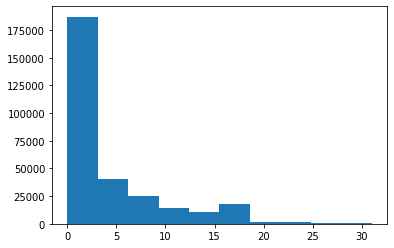

In [168]:
# Histogram to help evaluate the weight subtitution
quant = df['weight'].quantile(0.85)

series = df['weight'].copy()
series = np.where(series < quant, series, 0)
plt.hist(series)#, bins = np.arange(20))

In [169]:
# Solving missing declared_handling_days values by substituting with the mean/median. Mean might be better in this case.

tmp = df[df['seller_handling_days'].notnull()].copy()
mean = np.mean(tmp['seller_handling_days'])
median = np.median(tmp['seller_handling_days'])

df['new_declared_handling_days'] = df['seller_handling_days']
df['new_declared_handling_days'].fillna(mean, inplace = True)

# Number of rows with unavailable declared handling days after the substitution
print(len(df[df['new_declared_handling_days'].isna()]), median, mean)

0 1.0 1.00872


(array([ 92396.,      0.,      0.,      0.,      0., 156321.,      0.,
             0.,      0.,  51283.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

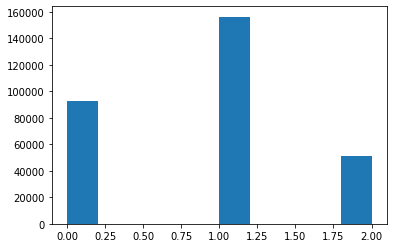

In [170]:
# Histogram to help evaluate the handling days subtitution
quant = df['declared_handling_days'].quantile(0.95)

series = df['declared_handling_days'].copy()
series = np.where(series < quant, series, 0)
plt.hist(series)#, bins = np.arange(20))

In [171]:
# setting the numerical variables as numerical variables (they come as strings)

df['shipment_method_id'] = df['shipment_method_id'].astype(int)
df['shipping_fee'] = df['shipping_fee'].astype(float)
df['carrier_min_estimate'] = df['carrier_min_estimate'].astype(int)
df['carrier_max_estimate'] = df['carrier_max_estimate'].astype(int)
df['category_id'] = df['category_id'].astype(int)
df['item_price'] = df['item_price'].astype(float)
df['quantity'] = df['quantity'].astype(int)
df['new_weight'] = df['new_weight'].astype(int)
df['new_declared_handling_days'] = df['new_declared_handling_days'].astype(int)

In [172]:
# And now we do the One-Hot encodings. (I have read that it is better to do -1, 1 binary encoding than 0, 1 encoding, then im going to do that)

'''for column in df.columns.tolist():
    if df[column].dtype == 'object':
        tmp = pd.get_dummies(df[column], prefix = column).astype(int)
        tmp.where(tmp == 1, -1, inplace = True)

        df = df.join(tmp)'''

cat_cols = ['shipment_method_id', 'category_id','package_size','b2c_c2c'] 
for column in cat_cols:
    
    print(column)
    tmp = pd.get_dummies(df[column], prefix = column).astype(int)
    tmp.where(tmp == 1, -1, inplace = True)

    df = df.join(tmp)

shipment_method_id
category_id
package_size
b2c_c2c


In [173]:
df.groupby(['delivery_time_buss_days']).count()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,category_id_30,category_id_31,category_id_32,package_size_LARGE_ENVELOPE,package_size_LARGE_PACKAGE,package_size_LETTER,package_size_NONE,package_size_PACKAGE_THICK_ENVELOPE,b2c_c2c_B2C,b2c_c2c_C2C
delivery_time_buss_days,,,,,,,,,,,,,,,,,,,,,
-50,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0,148,148,143,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
1,2789,2789,2639,2789,2789,2789,2789,2789,2789,2789,...,2789,2789,2789,2789,2789,2789,2789,2789,2789,2789
2,52587,52587,49695,52587,52587,52587,52587,52587,52587,52587,...,52587,52587,52587,52587,52587,52587,52587,52587,52587,52587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
72,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
73,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
'''handling_time = []
delivery_time = []
total_time_bd = []
total_time_cd = []
for t in range(partial.shape[0]):
    acceptance_time = datetime.fromisoformat(partial['acceptance_scan_timestamp'][t][0:10])
    payment_time = datetime.fromisoformat(partial['payment_datetime'][t][0:10])
    handling_time.append(np.busday_count(partial['payment_datetime'][t][0:10], partial['acceptance_scan_timestamp'][t][0:10],holidays = hld.flatten()))
    total_time_bd.append(np.busday_count(partial['payment_datetime'][t][0:10], partial['delivery_date'][t],holidays = hld.flatten()))
        #if payment is made past cutoff on a weekday, it is considered next business day
    if payment_time.hour >= 14 and payment_time.weekday() < 5:
        handling_time[t] = handling_time[t] - 1
        total_time_bd[t] = total_time_bd[t] - 1
    delivery = datetime.fromisoformat(partial['delivery_date'][t]) - acceptance_time
    total = datetime.fromisoformat(partial['delivery_date'][t]) - payment_time
    delivery_time.append(delivery.days)
    total_time_cd.append(total.days)

df['delivery_time_buss_days'] = total_time_bd
df.head()'''

In [174]:
# Now we normalize the data numerical data
real_cols = ['shipping_fee',
 'carrier_min_estimate',
 'carrier_max_estimate',
 'item_price',
 'quantity',
 'new_weight',
 'new_declared_handling_days']

for column in real_cols:
    mean = np.mean(df[column])
    std = np.std(df[column])
    df[column] = (df[column] - mean)/std

In [175]:
# formatting the timestamps to datetime instead of strings

df['acceptance_scan_timestamp'] = pd.to_datetime(df['acceptance_scan_timestamp'], format = '%Y-%m-%d %H:%M:%S', utc = True)
df['payment_datetime'] = pd.to_datetime(df['payment_datetime'], format = '%Y-%m-%d %H:%M:%S', utc = True)
df['delivery_date'] = pd.to_datetime(df['delivery_date'], format = '%Y-%m-%d', utc = True)


df['acceptance_scan_timestamp seconds'] = (df['acceptance_scan_timestamp'].values.astype(np.int64)/10**9).astype(int)
df['payment_datetime seconds'] = (df['payment_datetime'].values.astype(np.int64)/10**9).astype(int)
df['delivery_date seconds'] = (df['delivery_date'].values.astype(np.int64)/10**9).astype(int)

In [176]:
# Create the True handling time column and true handling time in seconds (because then it can be used as an integer values)
df['true handling time'] = df['acceptance_scan_timestamp'] - df['payment_datetime']
df['true handling time seconds'] = (df['true handling time'].values.astype(np.int64)/10**9).astype(int)

In [ ]:
df.shape

In [ ]:
df.columns[0:20]

In [ ]:
df.columns[21:40]


In [ ]:
df.columns[41:60]

In [ ]:
df.columns[61:80]

In [ ]:
df.columns[81:100]

In [177]:
from sklearn.neighbors import KNeighborsClassifier

In [335]:
x = df.copy()

In [179]:
x.drop(columns = (['seller_handling_days','weight_units', 'item_zip', 'buyer_zip', 'weight', 'declared_handling_days', 'record_number','b2c_c2c','seller_id','shipment_method_id','category_id','true handling time','package_size','acceptance_scan_timestamp','payment_datetime','delivery_date','delivery_time_buss_days','delivery_date seconds']), inplace = True)

In [180]:
x.head()

,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_price,quantity,new_weight,new_declared_handling_days,shipment_method_id_0,shipment_method_id_1,shipment_method_id_2,...,package_size_LARGE_ENVELOPE,package_size_LARGE_PACKAGE,package_size_LETTER,package_size_NONE,package_size_PACKAGE_THICK_ENVELOPE,b2c_c2c_B2C,b2c_c2c_C2C,acceptance_scan_timestamp seconds,payment_datetime seconds,true handling time seconds
0,-0.503421,0.771107,-0.374545,-0.077235,-0.126471,-0.122735,-0.004504,1,-1,-1,...,-1,-1,1,-1,-1,1,-1,1553638260,1553425009,213251
1,0.035381,0.771107,-0.374545,-0.149458,-0.126471,-0.087223,-0.004504,1,-1,-1,...,-1,-1,-1,-1,1,-1,1,1527969180,1527885834,83346
2,0.304783,0.771107,-0.374545,-0.155275,-0.126471,-0.087223,-0.521015,1,-1,-1,...,-1,-1,-1,-1,1,1,-1,1546896120,1546750920,145200
3,-0.503421,0.771107,-0.374545,-0.004042,-0.126471,-0.096101,-0.521015,1,-1,-1,...,-1,-1,-1,-1,1,1,-1,1545094560,1544984908,109652
4,-0.503421,0.771107,-0.374545,-0.105833,-0.126471,-0.140491,-0.004504,1,-1,-1,...,-1,-1,-1,-1,1,1,-1,1532735280,1532654402,80878


In [336]:
test = x[200001:300000]

In [337]:
test

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
200001,C2C,656455,1.0,2018-05-10 20:46:00.000-04:00,0,0.00,3,5,30909,07064,7,8.99,1,2018-05-09 02:28:24.000-04:00,2018-05-14,3,1,PACKAGE_THICK_ENVELOPE,200002
200002,B2C,78102,1.0,2018-05-14 11:41:00.000-05:00,0,2.99,3,5,75165,76825,0,10.50,1,2018-05-14 02:17:08.000-05:00,2018-05-16,0,1,PACKAGE_THICK_ENVELOPE,200003
200003,B2C,1144,0.0,2019-04-24 20:57:00.000-04:00,1,0.00,2,5,33174,11416,1,22.20,1,2019-04-23 21:47:17.000-04:00,2019-04-27,0,1,PACKAGE_THICK_ENVELOPE,200004
200004,B2C,16984,0.0,2018-02-22 21:13:00.000-08:00,0,0.00,3,5,91791,88081,5,9.95,1,2018-02-22 11:58:35.000-08:00,2018-02-26,13,1,PACKAGE_THICK_ENVELOPE,200005
200005,B2C,11865,1.0,2018-05-29 12:29:00.000-04:00,1,6.99,2,5,11716,80304,9,47.99,1,2018-05-28 15:55:55.000-04:00,2018-05-31,64,1,PACKAGE_THICK_ENVELOPE,200006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,C2C,162981,1.0,2019-08-22 10:49:00.000-04:00,0,0.00,3,5,30096,43214,6,21.95,1,2019-08-21 20:11:07.000-04:00,2019-08-24,4,1,PACKAGE_THICK_ENVELOPE,299996
299996,C2C,172379,5.0,2019-02-13 00:27:00.000-05:00,0,0.00,3,5,14607,78251,6,22.00,1,2019-02-09 15:55:37.000-05:00,2019-02-14,13,1,PACKAGE_THICK_ENVELOPE,299997
299997,C2C,2410232,1.0,2019-02-20 10:03:00.000-08:00,1,0.00,2,5,95632,48322,7,300.00,1,2019-02-18 08:34:21.000-08:00,2019-02-22,0,1,PACKAGE_THICK_ENVELOPE,299998
299998,C2C,280877,1.0,2019-06-20 15:51:00.000-07:00,0,0.00,3,5,89014,50533,25,12.95,1,2019-06-19 12:29:06.000-07:00,2019-06-22,6,1,PACKAGE_THICK_ENVELOPE,299999


In [182]:
x = x[0:200000]

In [183]:
y = df['delivery_time_buss_days'][0:200000]

In [184]:
target = df['delivery_time_buss_days'][200001:300000]

In [185]:
neigh3 = KNeighborsClassifier(n_neighbors=3)

In [186]:
neigh3.fit(x, y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
def get_loss(y_true, y_pred):
  early = y_pred[np.where(y_pred > y_true)]
  late = y_pred[np.where(y_pred < y_true)]

  early_y_true = y_true[np.where(y_pred > y_true)]
  late_y_true = y_true[np.where(y_pred < y_true)]

  #print(early, early_y_true, late, late_y_true)

  mean = np.ceil(np.ones(len(y_true))*np.mean(y_train))

  early_mean = mean[np.where(mean > y_true)]
  late_mean = mean[np.where(mean < y_true)]

  early_y_true_mean = y_true[np.where(mean > y_true)]
  late_y_true_mean = y_true[np.where(mean < y_true)]

  loss = np.abs(0.4*np.sum(early_y_true - early) + 0.6*np.sum(late - late_y_true))/len(y_true)
  loss_mean = np.abs(0.4*np.sum(early_y_true_mean - early_mean) + 0.6*np.sum(late_mean - late_y_true_mean))/len(y_true)
  
  #print(np.sum(early_y_true - early), np.sum(late_y_true - late))
  #print(loss, loss_mean)
  return loss, loss_mean

In [23]:
neigh3.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [187]:
y_pred = neigh3.predict(test)

C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [188]:
diff = y_pred - target
df_diff = pd.DataFrame(diff).reset_index()
df_diff.columns = ['Order', 'Difference']

Text(0.5, 1.0, 'Number of instances X days off')

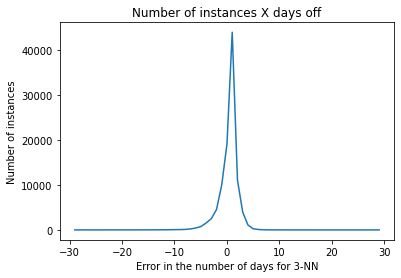

In [189]:
hist = np.histogram(diff, bins = np.arange(-30, 30))
plt.plot(hist[1][1:], hist[0])
plt.xlabel('Error in the number of days for 3-NN')
plt.ylabel('Number of instances')
plt.title('Number of instances X days off')

In [190]:
accuracy_score(y_pred, target)

0.43997439974399744

In [191]:
mean_absolute_error(y_pred, target)

1.098110981109811

In [192]:
mean_squared_error(y_pred, target)

4.088040880408804

In [357]:
s = df['payment_datetime']
str(s[1:2])

'1    2018-06-01 13:43:54.000-07:00\nName: payment_datetime, dtype: object'

In [318]:
def add_business_days(start_date, business_days_to_add):
    del_date = []
    for i in range(len(start_date)):
        start = datetime.fromisoformat(start_date[i])
        start_date.append(np.datetime64(start))          
        del_date.append((start + BusinessDay(business_days_to_add[i])).to_datetime64())
        hol = sum((((del_date[i] > hld_dt64)+0 + (start_date[i] < hld_dt64)+0)-2) > 0)
        del_date[i] += BusinessDay(hol)
    
    return del_date

In [278]:
del_date = []
start_date = []
for i in range(len(y_pred)):
    start = datetime.fromisoformat(df['payment_datetime'][i])
    start_date.append(np.datetime64(start))          
    del_date.append((start + BusinessDay(y_pred[i])).to_datetime64())
    hol = sum((((del_date[i] > hld_dt64)+0 + (start_date[i] < hld_dt64)+0)-2) > 0)
    if hol > 0:
        del_date[i] = del_date[i] + BusinessDay(hol)

C:\Users\winni\AppData\Local\Temp/ipykernel_4484/1543783733.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_date.append(np.datetime64(start))


In [297]:
s = test['payment_datetime'].to_frame()

In [334]:
test = test[['payment_datetime']][1]

KeyError: 1

In [317]:
delivery_date = add_business_days(s, y_pred)
delivery_date

In [31]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(x, y)
y_pred_5NN = neigh5.predict(test)

C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [32]:
diff_5NN = y_pred_5NN - target
df_diff_5NN = pd.DataFrame(diff_5NN).reset_index()
df_diff_5NN.columns = ['Order', 'Difference']

,Order
Difference,
-5,1425
-4,2337
-3,4282
-2,9386
-1,18360
0,46553
1,10930
2,3687
3,958


Text(0.5, 1.0, 'Number of instances X days off')

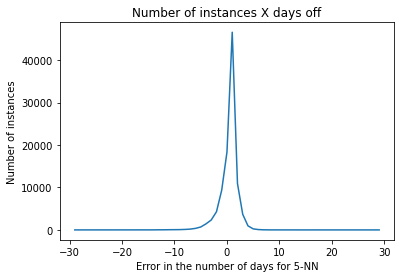

In [49]:
hist5 = np.histogram(diff_5NN, bins = np.arange(-30, 30))
plt.plot(hist5[1][1:], hist5[0])
plt.xlabel('Error in the number of days for 5-NN')
plt.ylabel('Number of instances')
plt.title('Number of instances X days off')

In [50]:
accuracy_score(y_pred_5NN, target)

0.46553465534655347

In [51]:
mean_absolute_error(y_pred_5NN, target)

1.041370413704137

In [52]:
mean_squared_error(y_pred_5NN, target)

3.9147191471914717

In [36]:
neigh10 = KNeighborsClassifier(n_neighbors=10)
neigh10.fit(x,y)
y_pred_10NN = neigh10.predict(test)

C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [37]:
diff_10NN = y_pred_10NN - target
df_diff_10NN = pd.DataFrame(diff_10NN).reset_index()
df_diff_10NN.columns = ['Order', 'Difference']

,Order
Difference,
-4,2401
-3,4390
-2,9477
-1,18612
0,48032
1,10028
2,3097
3,678
4,97


Text(0.5, 1.0, 'Number of instances X days off')

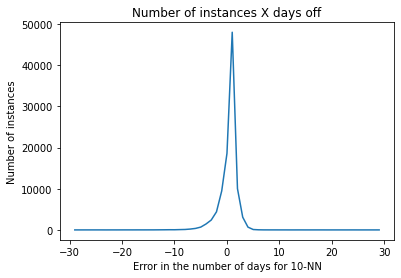

In [57]:
hist10 = np.histogram(diff_10NN, bins = np.arange(-30, 30))
plt.plot(hist10[1][1:], hist10[0])
plt.xlabel('Error in the number of days for 10-NN')
plt.ylabel('Number of instances')
plt.title('Number of instances X days off')

In [54]:
accuracy_score(y_pred_10NN, target)

0.4803248032480325

In [55]:
mean_absolute_error(y_pred_10NN, target)

1.0107101071010711

In [56]:
mean_squared_error(y_pred_10NN, target)

3.7722777227772277

In [58]:
neigh_manhattan = KNeighborsClassifier(n_neighbors=3, p=1)
neigh_manhattan.fit(x, y)
y_pred_manhattan = neigh_manhattan.predict(test)

C:\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [59]:
diff_manhatty_pred_manhattanred_manhattan - target

Text(0.5, 1.0, 'Number of instances X days off')

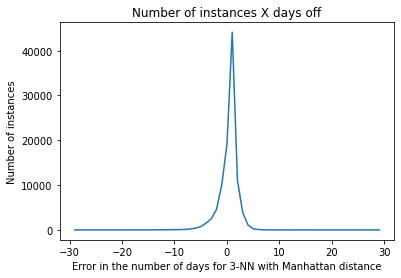

In [60]:
hist_man = np.histogram(diff_manhattan, bins = np.arange(-30, 30))
plt.plot(hist_man[1][1:], hist_man[0])
plt.xlabel('Error in the number of days for 3-NN with Manhattan distance')
plt.ylabel('Number of instances')
plt.title('Number of instances X days off')


In [61]:
accuracy_score(y_pred_manhattan, target)

0.44111441114411143

In [62]:
mean_absolute_error(y_pred_manhattan, target)

1.095320953209532

In [63]:
mean_squared_error(y_pred_manhattan, target)

4.049250492504925